Community analysis for cell-associated and cell-free rRNA 
Hisashi Endo - endo@scl.kyoto-u.ac.jp
25 May 2024

In [1]:
# Install related package
#install.packages("vegan")
#install.packages("ggplot2")
#install.packages("pheatmap")
#install.packages("tidyverse")
#install.packages("edgeR")
#install.packages("networkD3")
#install.packages("LaplacesDemon")
#install.packages("ggridges")
#install.packages("ggExtra")

#Import library
library("vegan")
library("ggplot2") 
library("pheatmap") 
library("tidyverse") 
library("edgeR") 
library("networkD3") # Sankey plot
library("LaplacesDemon") # Modality test
library(ggridges) # ridge density plot
library(ggExtra) # Add density plot to the ggplot

# Silence error message
options(warn = -1)

Warning message:
“ パッケージ ‘vegan’ はバージョン 4.3.3 の R の下で造られました ”
 要求されたパッケージ permute をロード中です 

 要求されたパッケージ lattice をロード中です 

This is vegan 2.6-6.1

── Attaching core tidyverse packages ─────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.0
── Conflicts ───────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
 要求されたパッケージ limma をロード中です 


 次のパッケージを付け加えます: ‘LaplacesDemon’ 


 以下のオブジェクトは ‘package:lubridate’ からマスクされています:

    dst, interval


 以下のオブジェクトは ‘package:purrr’ からマスクされています:

    partial


 以下のオブジェクトは ‘package:permute’ からマスクされています:

    Blocks




Load abundance table, metadata, etc.

In [2]:
# Change R environmental variable to double the default buffer size (to avoid errors when load large files)
Sys.setenv("VROOM_CONNECTION_SIZE" = 131072*2)

# Load QIIME2 data (use only Pelagic data for our paper)
ASV_count <- read_tsv("ASV_counts.protists_Pelagic.tsv", col_names = TRUE) 

# Load tax information for all ASVs including metazoa
ASV_tax <- read_tsv("ASV_PR2_taxonomy.edit.tsv", col_names = TRUE) 
colnames(ASV_tax)[1] <- "ASV_ID"

# Load count data for PR2_Lv5 (class-level) resolution
Lv5_count <- read_tsv("seqs.table.remrare.protist.table.lv5.edit.tsv", col_names = TRUE) 

# Load metadata
meta_gr <- as.data.frame(read_tsv("sample_metadata_R.tsv", col_names = TRUE)) #including sample lavel
# Extract samples used for this study
meta_gr_pelagic_raw <- meta_gr %>% filter(Biome == "Pelagic") %>% filter(Condition == "Raw") # Exclude coastal samples, then limit to day0 (raw) samples

# Load TD data
ctd_df <- read_tsv("CTD_All.txt", col_names = TRUE) 

Rows: 60 Columns: 4157
── Column specification ───────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr    (1): id
dbl (4156): 903e3141857c88516069efc819812951, 62a6d2e494be4c8c75b0c29419b0ab...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 10741 Columns: 9
── Column specification ───────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (8): Feature ID, Taxon, Taxon_Lv1, Taxon_Lv2, Taxon_Lv3, Taxon_Lv4, Taxo...
dbl (1): Confidence

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `Unclassified;Unclassified;Unclassified` -> `Unclassified;Unclassified;Unclassified...37`
• `Unclassified;Unclassified;Unclassified` -> `Unclassified;Unclassified;Unclassified...42`
• `Unclassifie

############ *** 1. Data standardization #########################


[1] 25878 25878 25878 25878 25878 25878 25878 25878 25878 25878 25878 25878
[13] 25878 25878 25878 25878 25878 25878 25878 25878 25878 25878 25878 25878
[25] 25878 25878 25878 25878 25878 25878 25878 25878 25878 25878 25878 25878
[37] 25878 25878 25878 25878 25878 25878 25878 25878 25878 25878 25878 25878
[49] 16388 25878 25878 25878 25878 25878 25878 25878 25878 25878 25878 25878

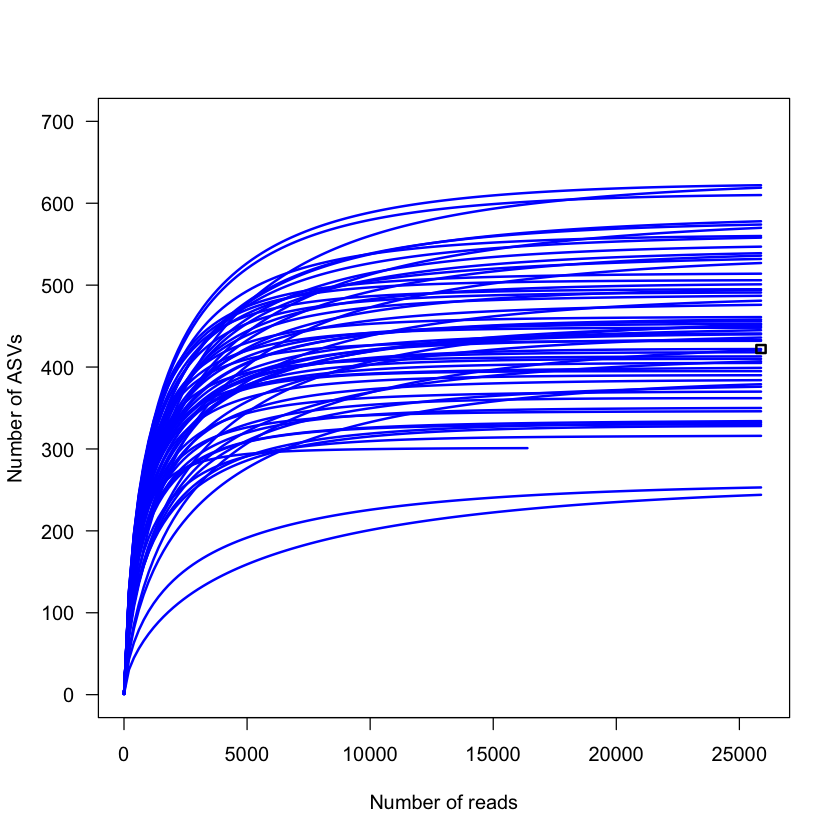

In [3]:
# Rarefy count table to unify sequence depth using "vegan::rrafefy" function
min_order <- sort(rowSums(ASV_count[,2:c(ncol(ASV_count))]))
# All the values are normalized to the 2nd smallest sample (25,878 reads)
set.seed(10) # Set seed to reproduce randomized sub-sampling 
rarefied <- as.data.frame(rrarefy(ASV_count[,2:c(ncol(ASV_count))], min_order[2]))
ASV_unicount <- cbind(ASV_count[1], rarefied)
rowSums(rarefied)
# Plot rarefaction curve
rarecurve(ASV_unicount[2:ncol(ASV_unicount)], step = 200, xlab = "Number of reads", ylab = "Number of ASVs",
          label = TRUE, xlim=c(0,26000), ylim=c(0,700), col="blue",lwd=2, lty=1, las=1)

# Convert Lv4 table from 0-1 frequency table
Lv5_count_stdz <- decostand(Lv5_count[,2:c(ncol(Lv5_count))], method="total", MARGIN=1)
Lv5_count_stdz <- cbind(Lv5_count[,1], Lv5_count_stdz)
# write_tsv(Lv5_count_stdz, "Lv5_count_stdz.table", col_names = TRUE)

############ 2. Heat map showing the class level relative abundance and ANOSIM #########################


Call:
anosim(x = ASV_unicount_select, grouping = meta_gr_pelagic_raw$Depth,      permutations = 9999, distance = "bray") 
Dissimilarity: bray 

ANOSIM statistic R: 0.4489 
      Significance: 1e-04 

Permutation: free
Number of permutations: 9999



Call:
anosim(x = ASV_unicount_select, grouping = meta_gr_pelagic_raw$Form,      permutations = 9999, distance = "bray") 
Dissimilarity: bray 

ANOSIM statistic R: 0.2499 
      Significance: 1e-04 

Permutation: free
Number of permutations: 9999



Call:
anosim(x = ASV_unicount_select, grouping = meta_gr_pelagic_raw$Station,      permutations = 9999, distance = "bray") 
Dissimilarity: bray 

ANOSIM statistic R: 0.03385 
      Significance: 0.2216 

Permutation: free
Number of permutations: 9999


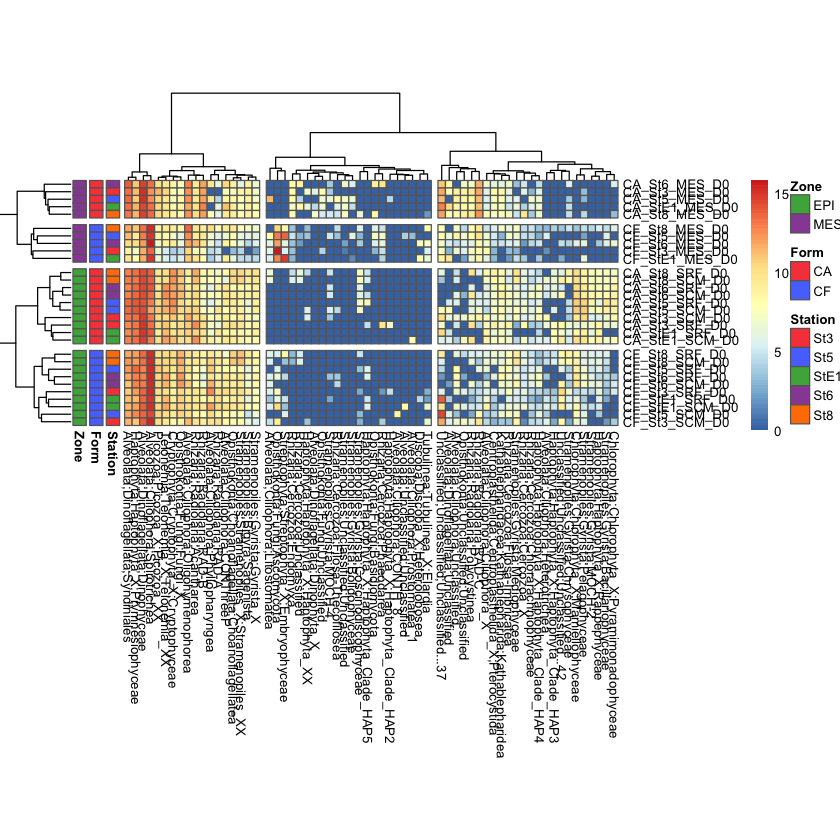

In [4]:
# Select samples
line_nums <- match(meta_gr_pelagic_raw$id, Lv5_count_stdz$id)
Lv5_count_stdz_select <- Lv5_count_stdz[c(line_nums), ]
ASV_unicount_select <- ASV_unicount[c(line_nums), ] # To calculate distance matrix based on ASV table

# Generate id-embedded df
Lv5_count_stdz_select <- Lv5_count_stdz_select[, colnames(Lv5_count_stdz_select) != "id"]
rownames(Lv5_count_stdz_select) <- meta_gr_pelagic_raw[,2]
ASV_unicount_select <- ASV_unicount_select[, colnames(ASV_unicount_select) != "id"]
rownames(ASV_unicount_select) <- meta_gr_pelagic_raw[,2]

# Remove taxa having the max contribution of less than 0.1% (0.001)
remove_taxa <- function(df) {
  max_values <- apply(df, 2, max)
  columns_to_remove <- names(max_values[max_values < 0.001])
  df[, -which(names(df) %in% columns_to_remove)]
}
Lv5_count_stdz_select2 <- remove_taxa(Lv5_count_stdz_select)


# Define the category shown in the heatmap
hm_annotation2 <- meta_gr_pelagic_raw[,c(4,8,6)]
rownames(hm_annotation2) <- meta_gr_pelagic_raw[,2] #Add corresponding row names

# Log transform the data
Lv5_count_stdz_select2_log <- decostand(Lv5_count_stdz_select2, method="log", MARGIN=1)

# Define colors for each category
hm_colour2 = list(
  Station = c(St3="#f74747", St5="#5977ff", StE1="#4DAF4A", St6="#984EA3", St8="#FF7F00"),
  Form = c(CA="#f74747", CF="#5977ff"),
  Zone = c(EPI="#4DAF4A", MES="#984EA3")
  #Depth = c(SRF="#5977ff", SCM="#4DAF4A", MES="#984EA3")
)

# Define cluster based on Bray curtis distance
  # Note that ASV-level clustering based on Bray-Curtis distance was used for sample clustering
drows = vegdist(ASV_unicount_select, method="bray", binary=FALSE, diag=FALSE, upper=FALSE, na.rm = FALSE)
  # Note that default Euclidian clustering was used for tax clustering
dcols = dist(t(Lv5_count_stdz_select2_log), method = "euclidean")

### Generate plots
pheatmap(Lv5_count_stdz_select2_log,
         annotation_row = hm_annotation2,
         annotation_colors = hm_colour2,
         main = "",
         scale = "none",
         cluster_col= TRUE,
         cluster_row= TRUE,
         clustering_distance_rows = drows,
         clustering_distance_cols = dcols,
         clustering_method = "ward.D2", # 本来のWard法(2乗あり)。Ward method (二乗なし)
         fontsize = 8,
         cutree_col = 3,
         cutree_row = 4,
         legend = TRUE,
         cellwidth = 4.5,
         cellheight = 4.5,
         border_color = "gray40"
         #color = colorRampPalette(c("white", "gray40","green", "blue", "red"))(20)
)

# ANOSIM 
anosim(ASV_unicount_select, meta_gr_pelagic_raw$Depth, permutations=9999, distance="bray")
anosim(ASV_unicount_select, meta_gr_pelagic_raw$Form, permutations=9999, distance="bray")
anosim(ASV_unicount_select, meta_gr_pelagic_raw$Station, permutations=9999, distance="bray")

############# 3. DEG analysis on the pelagic Day 0 samples ##################

[1] 1082   30

,group,lib.size,norm.factors
,<fct>,<dbl>,<dbl>
DRNA01,EPI_CF_D0,24857,0.8257434
DRNA03,EPI_CF_D0,23406,0.6917014
DRNA05,MES_CF_D0,16122,0.4378678
DRNA13,EPI_CF_D0,24221,0.9358737
DRNA15,EPI_CF_D0,23336,0.9422250
DRNA17,MES_CF_D0,12294,0.5678161
DRNA25,EPI_CF_D0,22631,0.8444804
DRNA27,EPI_CF_D0,18502,0.6214283
DRNA29,MES_CF_D0,21349,0.1925032


,DRNA01,DRNA03,DRNA05,DRNA13,DRNA15,DRNA17,DRNA25,DRNA27,DRNA29,DRNA37,⋯,PRNA09,PRNA13,PRNA14,PRNA15,PRNA19,PRNA20,PRNA21,PRNA25,PRNA26,PRNA27
62a6d2e494be4c8c75b0c29419b0ab15,0,0,9,0,0,0,0,0,0,0,⋯,16,0,0,41,0,0,24,0,0,0
c68917fa6183d1051b06940c56bca45c,0,0,0,0,0,0,0,0,0,0,⋯,0,25,0,0,0,9,0,0,0,0
536054620aa69449ca00935e2e7d5317,13,12,0,40,58,0,138,31,0,121,⋯,0,26,0,0,8,0,0,0,0,0
2e555af68b7a68197563d46c5502bf1e,0,0,0,0,0,0,86,0,0,35,⋯,0,0,0,0,23,56,0,27,30,0
6a47dd12adfe848a1ffa84cdeb9f6eae,4,5,0,2,4,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3c83dddca374ed3f7070f2e40d1e1065,0,0,13,0,0,0,0,0,0,0,⋯,0,57,0,0,0,0,0,0,0,0
009fb6192d965b9cd0d512222a1c287d,0,0,0,0,15,0,18,0,0,0,⋯,0,18,0,0,0,0,0,0,0,0
14b19066538260106e6b12d0e6e2ed38,5,0,0,0,0,0,0,0,0,0,⋯,0,6,0,0,0,23,0,5,0,0
27a8596860971c7ccf964de9d823f489,0,0,0,94,15,0,71,0,4,26,⋯,0,45,0,0,61,0,0,0,0,0
82565017b9a00e07b0e94fd86de109ad,0,0,0,0,0,0,17,0,0,4,⋯,0,72,0,0,27,39,0,0,0,0


DRNA01 DRNA03 DRNA05 DRNA13 DRNA15 DRNA17 DRNA25 DRNA27 DRNA29 DRNA37 DRNA39 
 24857  23406  16122  24221  23336  12294  22631  18502  21349  23858  23124 
DRNA41 DRNA49 DRNA51 DRNA53 PRNA01 PRNA02 PRNA03 PRNA07 PRNA08 PRNA09 PRNA13 
 17464  24410  24151  16732  25103  24391  20092  25004  24655  18955  22037 
PRNA14 PRNA15 PRNA19 PRNA20 PRNA21 PRNA25 PRNA26 PRNA27 
 21499  19043  15438  23517  18714  24193  24304  19359

   gEPI_CA_D0 gEPI_CF_D0 gMES_CA_D0 gMES_CF_D0
1           0          1          0          0
2           0          1          0          0
3           0          0          0          1
4           0          1          0          0
5           0          1          0          0
6           0          0          0          1
7           0          1          0          0
8           0          1          0          0
9           0          0          0          1
10          0          1          0          0
11          0          1          0          0
12          0          0          0          1
13          0          1          0          0
14          0          1          0          0
15          0          0          0          1
16          1          0          0          0
17          1          0          0          0
18          0          0          1          0
19          1          0          0          0
20          1          0          0          0
21          0

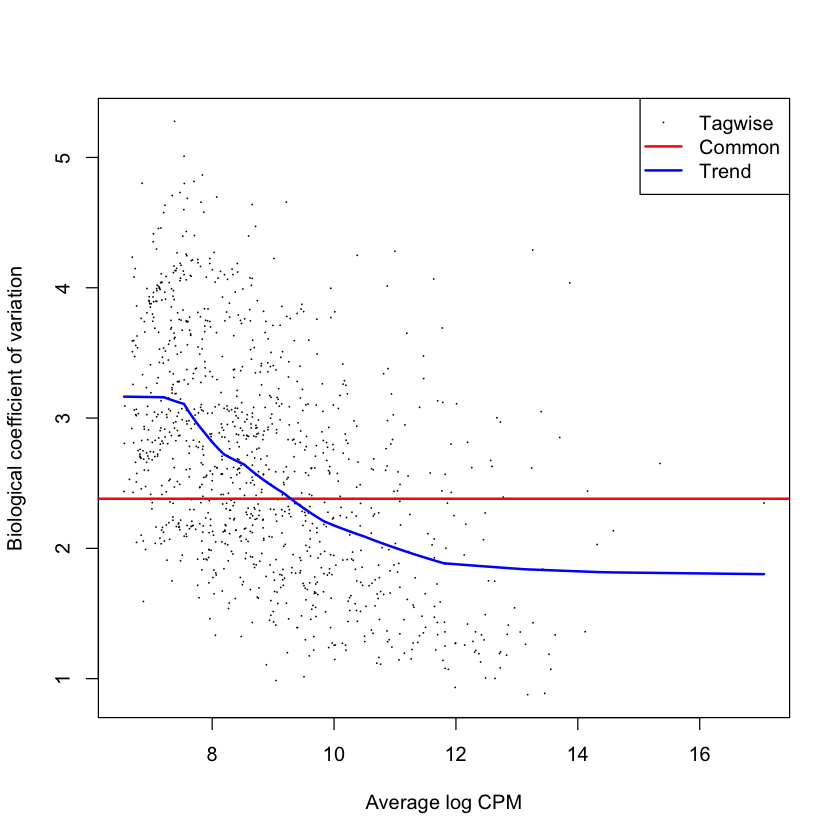

In [5]:
## Here we apply edgeR DEG analysis to detect enriched ASVs in the cell-free fractions ##

# Define starting df (Pelagic EPI samples at day 0)
df <- meta_gr %>% left_join(ASV_unicount, by="id") %>% filter(Biome == "Pelagic", Condition == "Raw") %>% select(-c(2:11)) # Remove coastal sample
# Make inverse matrix 
df_t <- as.data.frame(t(df[2:ncol(df)]))
colnames(df_t)[] <- df[,1]

# Define group (2 depths, 2 forms, and 1 days)
group <- factor(c("EPI_CF_D0","EPI_CF_D0","MES_CF_D0", # Cell-free 10+5 samples
                  "EPI_CF_D0","EPI_CF_D0","MES_CF_D0",
                  "EPI_CF_D0","EPI_CF_D0","MES_CF_D0",
                  "EPI_CF_D0","EPI_CF_D0","MES_CF_D0",
                  "EPI_CF_D0","EPI_CF_D0","MES_CF_D0",
                  "EPI_CA_D0","EPI_CA_D0","MES_CA_D0", # Cell-associated 10+5 samples
                  "EPI_CA_D0","EPI_CA_D0","MES_CA_D0",
                  "EPI_CA_D0","EPI_CA_D0","MES_CA_D0",
                  "EPI_CA_D0","EPI_CA_D0","MES_CA_D0",
                  "EPI_CA_D0","EPI_CA_D0","MES_CA_D0"),
                levels=c("EPI_CA_D0","EPI_CF_D0","MES_CA_D0","MES_CF_D0"))

# Make DGEList
d <- DGEList(counts = df_t, group = group) # Make DGEList object

# keep the genes having >=1 cpm in at least 4 samples (one)
keep <- rowSums(cpm(d) >= 1) >= 4
d_filt <- d[keep, , keep.lib.sizes=FALSE]
dim(d_filt) # Check dimension of df

# Calcurate TMM normalization factor
d_tmm <- calcNormFactors(d_filt, method = "TMM") 
# Check normalization factors
d_tmm$samples
d_tmm$counts
colSums(d_tmm$counts)

# Define count table used in the DEG analysis
d_deg <- d_tmm

# Define experimental design for pairwise comparison
g <- group
design <- model.matrix(~ 0 + g)
print(design)

# Estimate common dispersion, trended dispersions and tagwise dispersions 
d_deg <- estimateDisp(d_deg, design)
#Plot the genewise biological coefficient of variation (BCV) against gene abundance
plotBCV(d_deg)

# Fit data to the estimated distribution using "glmFit" function
fit <- glmFit(d_deg, design, prior.count=0.125) # Adding prior count of 0.125 as default

# Design comparison list 
my.contrasts <- makeContrasts(
  EPI = gEPI_CF_D0-gEPI_CA_D0, # Epipeagic cell-lysis index (Epi-CLI)
  MES = gMES_CF_D0-gMES_CA_D0, # Mesopelagic cell-lysis index (Mes-CLI)
  EEI = gEPI_CA_D0-gMES_CA_D0, # Epipelagic Enrichment Index (EEI)
  levels=design
)

# Make a function to execute DEG analysis and generate plot
execute_DEG <- function(data=fit, comparison="EPI"){
  # Execute glmLRT
  test <- glmLRT(fit, contrast = my.contrasts[, comparison])

  # Extracts the most differentially abundant ASVs with FDR control 
  table <- as.data.frame(topTags(test, adjust.method = "BH", n = nrow(count)), row.names = NULL, sort.by="FDR")
  table　<- cbind(rownames(table), table)
  colnames(table)[1] <- "ASV_ID"
  
  # Merge with annotation results
  table <- table %>% left_join(ASV_tax, by="ASV_ID") %>% distinct(ASV_ID, .keep_all = TRUE)  # Remove redundant rows 
  
  # Categorize DA ASVs
  Response <- NULL  # Define empty object
  Factor <- NULL
  for (i in 1:nrow(table)){
    if (table$FDR[i] <= 0.1 && table$logFC[i] >= 2){
      Response[i] <- "Up"
      Factor[i] <- 0.8
    } else if (table$FDR[i] <= 0.1 && table$logFC[i] <= -2){
      Response[i] <- "Down"
      Factor[i] <- 0.8
    } else {
      Response[i] <- "nonDEG"
      Factor[i] <- 0.3
    }
  }
  DEG_table <- cbind(table, as.data.frame(Response), as.data.frame(Factor))
  DEG_simple <<- DEG_table[,c(1,2,3,15)] # Assign values with the persistent assignment operator
  
  # Define color and order
  col_1 <- c('#4363d8', '#e6194B', 'gray40')
  col_2 <- c('blue', 'Red', 'gray20')
  DEG_table$Response <- factor(DEG_table$Response, levels=c("Up", "Down", "nonDEG"))

  # Make MA plot  
  ma <- DEG_table %>% #filter(Response == "Up" | Response == "Down") %>% 
    ggplot(aes(x=logCPM, y=logFC, color=Response, fill=Response)) +
    geom_point(shape=16, size=1.5, alpha=Factor) +
    theme_classic() +
    theme(legend.position="none") +
    scale_color_manual(values = col_1) +
    scale_fill_manual(values = col_1)
  ggsave(filename = paste("Fig.MA_",comparison,".pdf", sep = ""), plot= ma, width=110, height=100, units="mm", dpi = 300)
}

# List for the loop
comp_list <- c("EPI", "MES", "EEI")

# Make an annotation table to add DEG category
DEG_summary <- as.data.frame(rownames(d_tmm$counts)) 
colnames(DEG_summary) <- "ASV_ID"
DEG_summary <- DEG_summary %>% left_join(ASV_tax, by="ASV_ID") %>% distinct(ASV_ID, .keep_all = TRUE)  # Remove redundant rows 

# Exexute DEG workflow
for (i in comp_list){
  execute_DEG(data=fit, comparison=i)
  DEG_summary <- DEG_summary %>% left_join(DEG_simple, by = "ASV_ID")
}

colnames(DEG_summary)[10:18] <- c("logFC_EPI","logCPM_EPI","EPI","logFC_MES","logCPM_MES", "MES","logFC_EEI","logCPM_EEI", "EEI")
# Save table summarizing DEG
write.table(DEG_summary, file = paste("DEG_summary.table", sep = ""), col.names = T, row.names = F, sep = "\t")


############# 4. Boxplot of logFC for the major clades in the pelagic Day 0 samples ##################


Rows: 1082 Columns: 18
── Column specification ───────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (11): ASV_ID, Taxon, Taxon_Lv1, Taxon_Lv2, Taxon_Lv3, Taxon_Lv4, Taxon_L...
dbl  (7): Confidence, logFC_EPI, logCPM_EPI, logFC_MES, logCPM_MES, logFC_EE...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


             Taxon_Lv4   n
1       Dinoflagellata 312
2           Ciliophora 274
3         Haptophyta_X 112
4           Radiolaria  74
5          Telonemia_X  44
6              Gyrista  40
7     Choanoflagellata  26
8                Fungi  26
9               Bigyra  20
10       Cryptophyta_X  16
11           Picozoa_X  16
12        Unclassified  16
13            Cercozoa  10
14       Chlorophyta_X  10
15     Kathablepharida   6
16     Stramenopiles_X   6
17      Streptophyta_X   6
18 Centroplasthelida_X   4
19         Tubulinea_X   4
20  Cryptophyta_X:nucl   2
21      Opisthokonta_X   2


Picking joint bandwidth of 1.74



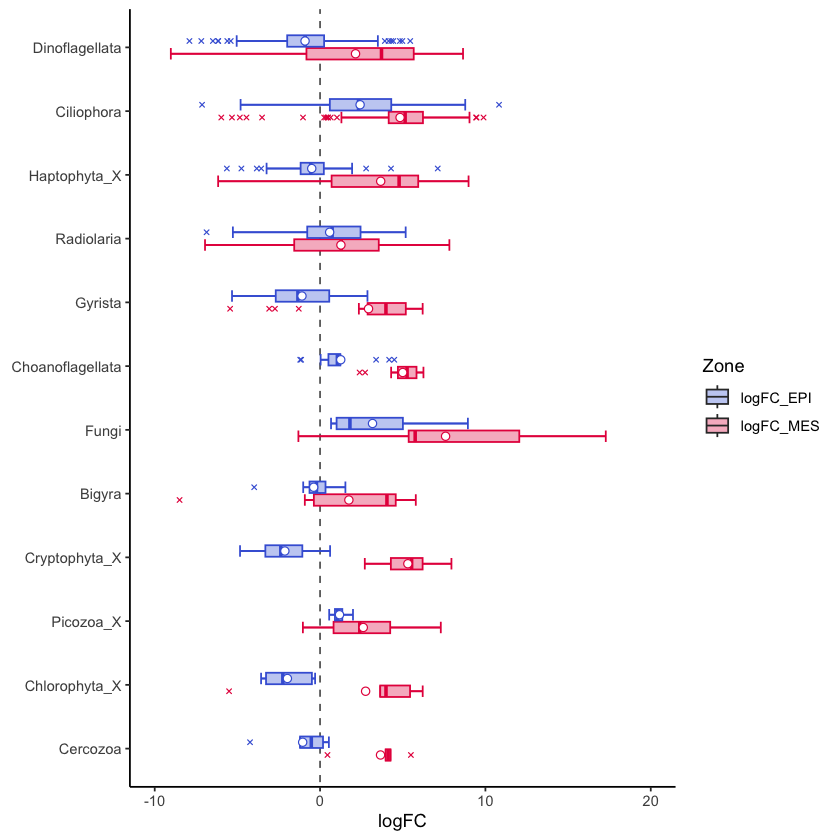

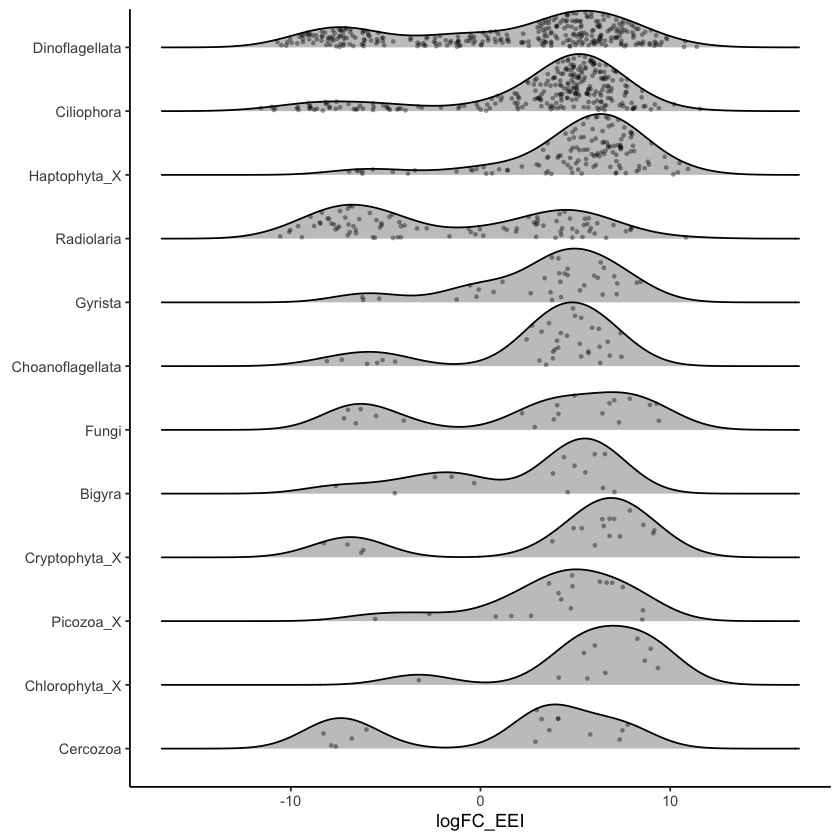

In [6]:

# Read the summary table
DEG_summary <- read_tsv("DEG_summary.table", col_names = TRUE) 

# Remove O values then convert to tidy data
# logFC=0 means there was no reads mapped to the ASVs
DEG_summary_tidy <- DEG_summary %>% filter(logFC_EPI != 0 & logFC_MES != 0) %>% 
                    pivot_longer(cols = c(logFC_EPI, logFC_MES), 
                                 names_to = "Zone",
                                 values_to = "logFC")

  # !! Note that the analysis was done only for the ASVs having logFC values in the both surface and deep layers. 

# Define list
 # Nutrition mode order (not used)
tax.list <- c("Streptophyta_X", "Chlorophyta_X", "Gyrista", "Haptophyta_X", "Cryptophyta_X", "Dinoflagellata", "Stramenopiles_X", 
              "Tubulinea_X", "Kathablepharida", "Bigyra", "Cercozoa", "Picozoa_X","Fungi", "Choanoflagellata", "Radiolaria", "Ciliophora")
 # ASV count order (used)
tax4_list <- c("Dinoflagellata","Ciliophora","Haptophyta_X","Radiolaria","Gyrista","Choanoflagellata","Fungi","Bigyra",
               "Cryptophyta_X","Picozoa_X","Chlorophyta_X","Cercozoa","Kathablepharida","Stramenopiles_X","Streptophyta_X","Tubulinea_X")


# Convert order (to put the EPI first), then also change the order of taxon
nASV <- count(DEG_summary_tidy, Taxon_Lv4) %>% arrange(-n) %>% as.data.frame()
print(nASV)
DEG_summary_tidy2 <- DEG_summary_tidy %>% transform(Zone= factor(Zone, levels = c("logFC_MES","logFC_EPI"))) %>%
  transform(Taxon_Lv4 = factor(Taxon_Lv4, levels = rev(tax4_list)))


# Make Box plot for CLI
bop2 <- DEG_summary_tidy2 %>% 
  filter(Taxon_Lv4 != "Kathablepharida" & Taxon_Lv4 != "Stramenopiles_X" & Taxon_Lv4 != "Streptophyta_X" & Taxon_Lv4 != "Tubulinea_X") %>%  # Filter out rare (=<2) taxa and Unclassified Eukaryota
  ggplot(aes(x=Taxon_Lv4, y=logFC, fill=Zone, colour=Zone)) +
  geom_abline(intercept=0, slope=0, colour='gray40', linetype=2) +
  stat_boxplot(geom = "errorbar", width=0.4) +
  geom_boxplot(width=0.4, outlier.size = 1, outlier.shape = 4) + 
  #geom_boxplot(outlier.shape = NA, width=0.4) + # Remove outliers
  scale_fill_manual(values=c('#f7bac9', '#c6d0f3')) +
  scale_colour_manual(values=c('#e6194B', '#4363d8')) +
  scale_y_continuous(limits = c(-10, 20)) +
  stat_summary(fun = "mean", geom = "point", shape = 21, size = 2, fill = "white", position = position_dodge(0.4)) +
  #geom_jitter(size = 0.2) +
  theme_classic() +
  theme(axis.title.y = element_blank()) +
  #facet_grid(Zone ~ .) +
  coord_flip() + guides(fill = guide_legend(reverse = TRUE), colour=FALSE) #Legendの順序を変える
bop2

# Arrange tax order
DEG_summary_arrange <- DEG_summary %>%  transform(Taxon_Lv4 = factor(Taxon_Lv4, levels = rev(tax4_list)))

# Make Box plot for EEI
bop4 <- DEG_summary_arrange %>%
  filter(Taxon_Lv4 != "Unclassified" & Taxon_Lv4 != "Cryptophyta_X:nucl" & Taxon_Lv4 != "Opisthokonta_X" & Taxon_Lv4 != "Tubulinea_X" & Taxon_Lv4 != "Kathablepharida" & Taxon_Lv4 != "Stramenopiles_X") %>%  # Filter out rare (=<3) taxa and Unclassified Eukaryota
  filter(logFC_EEI != 0) %>%  #  1.16.. はTublinea_x (1サンプルのみ) を消すための処理」
  ggplot(aes(x=logFC_EEI, y=Taxon_Lv4, group = Taxon_Lv4)) +
  stat_density_ridges(fill = "gray40", scale = 1, jittered_points = TRUE, position = "points_sina", alpha = 0.4, point_size = 1, point_shape = 16) +
  #geom_density_ridges(fill = "#00AFBB", scale = 1, alpha = 0.7) +
  theme_classic() +
  theme(axis.title.y = element_blank()) +
  theme(legend.position = "none")
bop4



Statistical test for all the taxonomic groups
  # 1. Test if the lysis index is different between epipelagic and mesopelagic (Mann-Whitney U test)
  # 2. Test if the habitat index (EEI) is bimodal or not (LaplacesDemon::is.multimodal)

In [7]:
# Make function to check if the distribution is mulimodal (not unimodal) and has peaks in both positive and negative values
# LaplacesDemon::is.multimodal is not enough as there is a possibility that a clade has two peaks in epipelagic

test.habitat.multimodality <- function (x, min.size = 0.1){
  if (max(Modes(x, min.size)[[1]]) > 0 && min(Modes(x, min.size)[[1]]) < 0)
    return(TRUE)
  else 
    return(FALSE)}


# Check modality
for (i in tax4_list){
  select_df <- DEG_summary %>% filter(logFC_EEI != 0) %>% 
    filter(Taxon_Lv4 == i)
  tmode <- Modes(select_df$logFC_EEI, min.size=0.1)
  bimodal <- test.habitat.multimodality(select_df$logFC_EEI, min.size=0.1)
  print(paste(i, ": #ASVs is", nrow(select_df), ", bimodality is", bimodal))
}

[1] "Dinoflagellata : #ASVs is 306 , bimodality is TRUE"
[1] "Ciliophora : #ASVs is 260 , bimodality is TRUE"
[1] "Haptophyta_X : #ASVs is 125 , bimodality is FALSE"
[1] "Radiolaria : #ASVs is 91 , bimodality is TRUE"
[1] "Gyrista : #ASVs is 33 , bimodality is FALSE"
[1] "Choanoflagellata : #ASVs is 34 , bimodality is TRUE"
[1] "Fungi : #ASVs is 20 , bimodality is TRUE"
[1] "Bigyra : #ASVs is 14 , bimodality is FALSE"
[1] "Cryptophyta_X : #ASVs is 18 , bimodality is TRUE"
[1] "Picozoa_X : #ASVs is 17 , bimodality is TRUE"
[1] "Chlorophyta_X : #ASVs is 10 , bimodality is FALSE"
[1] "Cercozoa : #ASVs is 15 , bimodality is TRUE"
[1] "Kathablepharida : #ASVs is 3 , bimodality is TRUE"
[1] "Stramenopiles_X : #ASVs is 7 , bimodality is FALSE"


ERROR: Error in if (max(Modes(x, min.size)[[1]]) > 0 && min(Modes(x, min.size)[[1]]) < :  TRUE/FALSE が必要なところが欠損値です 


############# *** 10. Scatter plot showing habitat preference and MES lysis index ##################

Rows: 3149 Columns: 29
── Column specification ───────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (11): ASV_ID, Taxon, Taxon_Lv1, Taxon_Lv2, Taxon_Lv3, Taxon_Lv4, Taxon_L...
dbl (18): Confidence, Ave_EPI_CA, Max_EPI_CA, Ave_MES_CA, Max_MES_CA, Ave_EP...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



	Spearman's rank correlation rho

data:  LevFreq_summary_sel$logFC_MES and LevFreq_summary_sel$logFC_EEI
S = 11074880, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.7790638 


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
You specified groupcolour = TRUE as well as a colour parameter for a marginal plot. The colour parameter will  be ignored in favor of using colours mapped from the scatter plot.

You specified groupfill = TRUE as well as a fill parameter for a marginal plot. The fill parameter will  be ignored in favor of using fills mapped from the scatter plot.

You specified groupcolour = TRUE as well as a colour parameter for a marginal plot. The colour parameter will  be ignored in favor of using colours mapped from the scatter plot.

You specified groupfill = TRUE as well as a fill parameter for a marginal plot. The fill parameter will  be ignored in favor of using fills mapped from the scatter plot.

`geom_smooth()` using formula = 'y ~ x'


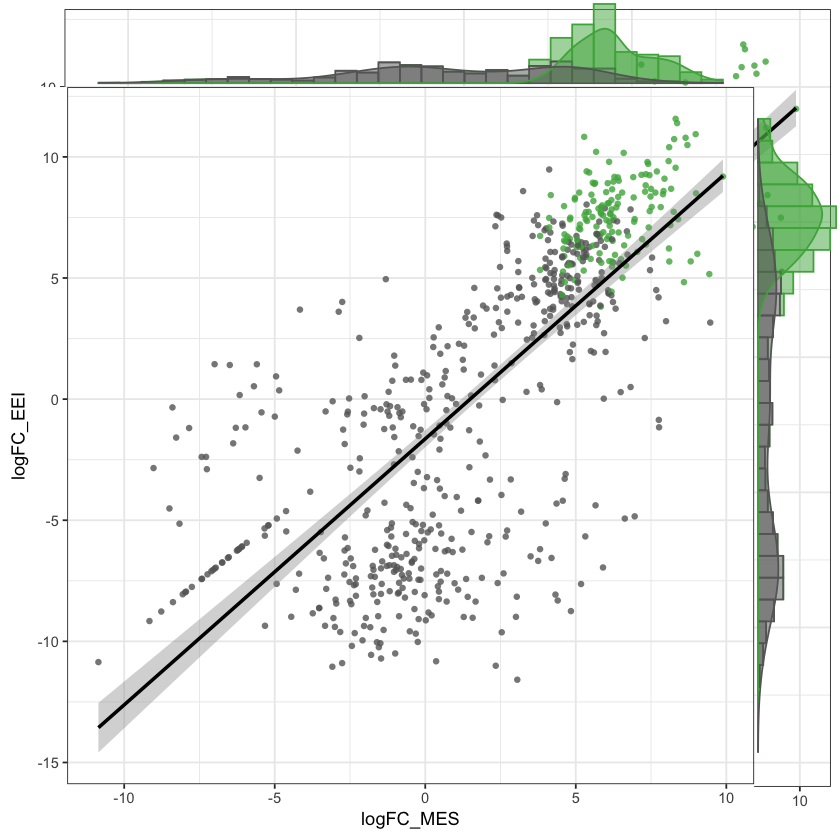

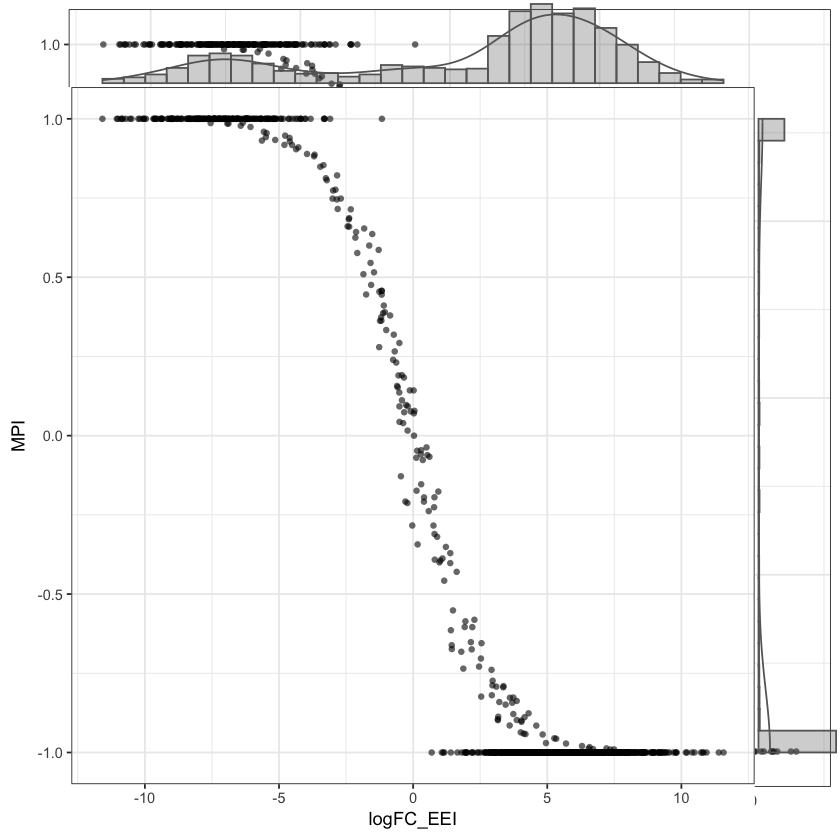

In [8]:
# Read summary table (DEGs were calculated for the Pelagic and raw (day 0) samples)
LevFreq_summary <- read_tsv("LevFreq_summary.table", col_names = TRUE) 

# Define a new column showing ASVs having both Up-expressed in MES and EEi
LevFreq_summary_sel <- LevFreq_summary %>% filter(logFC_MES != 0 & logFC_EEI != 0)

Intersection <- NULL
for (i in 1:nrow(LevFreq_summary_sel)){
  if (LevFreq_summary_sel$MES[i] == "Up" && LevFreq_summary_sel$EEI[i] == "Up"){
    Intersection[i] <- "Yes"
  } else {
    Intersection[i] <- "No"
  }
}
LevFreq_summary_sel_IS <- cbind(LevFreq_summary_sel, as.data.frame(Intersection))
# Write table
write.table(LevFreq_summary_sel_IS, file = paste("LevFreq_summary_sel_IS.table", sep = ""), col.names = T, row.names = F, sep = "\t")

# Compare MES enrichment and lysis index in MES
col_1_edit <- c('gray40',"#4DAF4A") 
col_1_edit2 <- c( '#e6194B', 'gray40','#4363d8')

# Correlation sanslysis
LevFreq_summary_sel <- LevFreq_summary %>% filter(logFC_MES != 0 & logFC_EEI != 0)
cor.test(LevFreq_summary_sel$logFC_MES, LevFreq_summary_sel$logFC_EEI, method="spearman") # -0.7790638  S = 89179230, p-value < 2.2e-16


# Scatter plot
# Compare CLI(MES) and EEI
sc1 <- LevFreq_summary_sel_IS %>% 
  filter(logFC_MES != 0 & logFC_EEI != 0) %>% 
  ggplot(aes(x=logFC_MES, y=logFC_EEI)) +  #  fill=EEI, colour=EEI
  geom_point(aes(color=Intersection), shape=16, size=1.5, alpha=0.8) +
  geom_smooth(method = lm, colour="black") +
  scale_color_manual(values = col_1_edit) +
  scale_fill_manual(values = col_1_edit) +
  guides(alpha = "none", color = "none") +
  theme_bw()
sc1
sc1d <- ggMarginal(sc1, type = "densigram", groupColour = TRUE, groupFill = TRUE, 
                   size = 8, margins = "both", colour = "gray40", fill = "gray40", alpha = .5) 
print(sc1d)


# Compare EEI and MPI (like logistic curve)
# Due to adding pseudo-count of 0.125, EEI values became more contious accepting ASVs emerged only in the one treatment.
sc3 <- LevFreq_summary %>% 
  ggplot(aes(x=logFC_EEI, y=MPI)) +  #  fill=EEI, colour=EEI
  geom_point(shape=16, size=1.5, alpha=0.6) +
  theme_bw() +
  scale_color_manual(values = col_1_edit) +
  scale_fill_manual(values = col_1_edit) +
  theme(legend.position="none") 
sc3
sc3d <- ggMarginal(sc3, type = "densigram", size = 8, margins = "both", colour = "gray40", fill = "gray40", alpha = .3) 
print(sc3d)
